Use at least two spatial data sets of your choosing, preferably related to your project:

1. project them to a projected (non spherical) coordinate system.

2. Create at least two different maps, with no bounding box, and a title, and at least two layers, showing data attributes as choroplethic maps (polygons or points) with an appropriate colormap.

Incorporate into your processing and map creation

* a spatial join

* a buffer, and

* distance calculation



## Import and Load Packages

In [1]:
#Data, Plotting, Mapping
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import fiona #read_file uses Fiona to handle the actual reading and writing of files (can handle Shapefiles and GeoJSON formatted files)
pylab.rcParams['figure.figsize'] = 10, 8

#APIs
import json      # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs
import pprint    # library for cleanly printing Python data structures
pp = pprint.PrettyPrinter()

import warnings 
warnings.filterwarnings('ignore')

## Clean and Load Census Data

In [2]:
#census API data
endpoint_url = "https://api.census.gov/data/2015/acs/acs5/subject?get=S1903_C02_001E,S1101_C01_009E&for=tract:*&in=state:06%20county:001&key=716a1bb1957c238ee8cedf7262e227a3a3220d32"
response = requests.get(endpoint_url)
results = response.text

data = json.loads(results)
print(type(data))
pp.pprint(data)

<class 'list'>
[['S1903_C02_001E', 'S1101_C01_009E', 'state', 'county', 'tract'],
 ['174113', '1286', '06', '001', '400100'],
 ['141806', '832', '06', '001', '400200'],
 ['84598', '2489', '06', '001', '400300'],
 ['102386', '1801', '06', '001', '400400'],
 ['76038', '1624', '06', '001', '400500'],
 ['60804', '701', '06', '001', '400600'],
 ['39614', '1793', '06', '001', '400700'],
 ['59886', '1572', '06', '001', '400800'],
 ['57003', '1013', '06', '001', '400900'],
 ['44766', '2533', '06', '001', '401000'],
 ['59500', '2028', '06', '001', '401100'],
 ['78203', '1250', '06', '001', '401200'],
 ['36788', '1727', '06', '001', '401300'],
 ['28532', '1516', '06', '001', '401400'],
 ['48490', '1002', '06', '001', '401500'],
 ['37946', '731', '06', '001', '401600'],
 ['72386', '1241', '06', '001', '401700'],
 ['26806', '725', '06', '001', '401800'],
 ['41500', '880', '06', '001', '402200'],
 ['29835', '1189', '06', '001', '402400'],
 ['19042', '725', '06', '001', '402500'],
 ['20270', '655', 

In [33]:
#put data into dataframe, rename columns and get rid of first row headers
census = pd.DataFrame.from_records(data)
census.columns = ["income","households","state","county","tract"]
census = census.iloc[1:]
census = census.drop(['state','county'], axis=1).reset_index()
census = census.drop(['index'], axis = 1)
census.head()

,income,households,tract
0,174113,1286,400100
1,141806,832,400200
2,84598,2489,400300
3,102386,1801,400400
4,76038,1624,400500


## Clean and Merge Parcel and Tax Data

In [13]:
#Loading Polygon Shapefile
parcels = gpd.read_file('Alameda County Parcel Boundaries/geo_export_a85caf8b-4f4f-46a5-be18-af34498f0784.shp')
parcels_clean = parcels.drop(['page','book','editor','clca_categ','fid_parcel'], axis=1)
#print(type(parcels))
#print(parcels.head())

In [223]:
#load and drop fields from tax roll file
tax = pd.read_csv('Assessor_s_Office_Secured_Tax_Roll_-_2017_2018.csv')
tax_clean = tax.drop(['Situs Unit','TRA Primary','TRA Secondary','CLCA Land','Fixtures','BPP','HPP','CLCA Imps','Source','HOEX','OTEX','Print Parcel','Situs Zip + 4', 'Mailing Address Street','Mailing Address Unit','Mailing Address City State','Mailing Address Zip','Mailing Address Zip + 4','CKDIGIT','WSEQ','Mailing Address Effective Date','Econ Unit','Latest Document Input Date','Delete Date'], axis=1)

In [ ]:
#clean commas and make int for calculations
tax_clean['Use Code']= tax_clean['Use Code'].str.replace(',', '')

tax_clean['Land']= tax_clean['Land'].str.replace(',', '')
tax_clean['Land'] = tax_clean['Land'].astype('int')

tax_clean['Imps']= tax_clean['Imps'].str.replace(',', '')
tax_clean['Imps'] = tax_clean['Imps'].astype('int')

tax_clean['Total Net Value']= tax_clean['Total Net Value'].str.replace(',', '')
tax_clean['Total Net Value'] = tax_clean['Total Net Value'].astype('int')


#tax_clean['Situs Street Number'] = tax_clean['Situs Street Number'].astype('str')
#tax_clean['Situs Street Number'] = tax_clean['Situs Street Number'].str.replace(',', '')

#tax_clean['Latest Document Series']= tax_clean['Latest Document Series'].astype('str')
#tax_clean['Latest Document Series']= tax_clean['Latest Document Series'].str.replace(',', '')

#tax_clean['Latest Document Prefix']= tax_clean['Latest Document Prefix'].astype('str')
#tax_clean['Latest Document Prefix']= tax_clean['Latest Document Prefix'].str.replace(',', '')

tax_clean.head()

In [225]:
tax_parcels = pd.merge(parcels_clean, tax_clean, left_on="apn_sort", right_on="Sort Parcel", how="inner")

oakland_parcels = tax_parcels[tax_parcels['Situs City']=='OAKLAND']

oakland_parcels = oakland_parcels[oakland_parcels['geometry'].notnull()]
#oakland_parcels_clean.shape: 98,460 parcels, lost 300k+ parcels

In [226]:
#dropping extra spatial fields from parcel data
oakland_parcels = oakland_parcels.drop(['shape_st_4','shape_st_1','sub_parcel', 'date_updat','shape_stle', 'centroid_x', 'shape_star', 'comments', 'shape_st_3','apn', 'shape_st_2', 'centroid_y', 'parcel', 'date_creat', 'Sort Parcel'],1)

In [176]:
oakland_parcels.head()

,apn_sort,geometry,Situs Street Number,Situs Street Name,Situs City,Situs Zip,Land,Imps,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code
0,048 629806800,POLYGON ((-122.1203618878905 37.75620960906961...,21,MARVIN CT,OAKLAND,94605,99967,118540,211507,"2,015","233,313",08/20/2015 12:00:00 AM,1100
1,048 629800302,POLYGON ((-122.1238375824534 37.75571233182055...,"10,709",COTTER ST,OAKLAND,94605,97680,228104,318784,"2,009","294,376",09/11/2009 12:00:00 AM,1100
2,048 629907100,POLYGON ((-122.1232337216532 37.75211193059634...,"4,734",SHETLAND AVE,OAKLAND,94605,35913,54715,83628,"2,013","311,619",09/19/2013 12:00:00 AM,1100
3,048 631302300,POLYGON ((-122.1250419508898 37.75428601190077...,"4,728",SCOTIA AVE,OAKLAND,94605,79230,80026,152256,"2,013","237,972",07/10/2013 12:00:00 AM,1100
4,048 643203900,POLYGON ((-122.1285286631322 37.76246225016029...,448,ELYSIAN FIELDS DR,OAKLAND,94605,269280,628320,890600,"2,015","285,900",10/23/2015 12:00:00 AM,1100


In [180]:
oakland_parcels.shape

(98460, 13)

## Zoning

In [178]:
zoning = gpd.read_file('City-wide Zoning Map/geo_export_e3412bab-6a4e-42e8-893b-592036e2869f.shp')
zoning.head()

,overlay,ordinance,znlabel,expiredate,perimeter,area,test,lastupdate,effctvdate,basezone,geometry
0,/S-19,12875,CIX-1/S-19,,1015.466097,5.512397e+06,CIX-1/S-19,20090304,20080718,CIX-1,POLYGON ((-122.2857308439033 37.82232725511785...
1,/S-19,12875,CIX-1/S-19,,1015.466097,5.744007e+05,CIX-1/S-19,20090304,20080718,CIX-1,POLYGON ((-122.2812909540165 37.80236514210691...
2,/S-19,12875,CIX-1/S-19,,17791.906465,3.983032e+06,CIX-1/S-19,20090304,20080718,CIX-1,(POLYGON ((-122.2993166973065 37.8062938028413...
3,,,OS (NP),,1498.555904,1.389631e+05,OS (NP),20090304,,OS (NP),POLYGON ((-122.1773177128875 37.72609018686309...
4,,,R-40,,2286.429366,1.662382e+05,R-40,20090304,,R-40,POLYGON ((-122.1824047150539 37.72864462309264...


In [ ]:
zoning_clean = zoning[zoning['geometry'].notnull()]
#zoning_clean.shape: 993 zones, lost 52 zones


In [184]:
zoning_clean = zoning_clean.drop(['overlay', 'ordinance', 'znlabel', 'expiredate', 'perimeter', 'area', 'test', 'lastupdate', 'effctvdate'],1)

In [200]:
oakland_parcels_zone.shape

(112329, 15)

In [188]:
oakland_parcels_zone = gpd.sjoin(oakland_parcels,zoning_clean, how="inner", op='intersects')
oakland_parcels_zone.head()

,apn_sort,geometry,Situs Street Number,Situs Street Name,Situs City,Situs Zip,Land,Imps,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code,index_right,basezone
0,048 629806800,POLYGON ((-122.1203618878905 37.75620960906961...,21,MARVIN CT,OAKLAND,94605,99967,118540,211507,"2,015","233,313",08/20/2015 12:00:00 AM,1100,130,R-30
1,048 629800302,POLYGON ((-122.1238375824534 37.75571233182055...,"10,709",COTTER ST,OAKLAND,94605,97680,228104,318784,"2,009","294,376",09/11/2009 12:00:00 AM,1100,130,R-30
2,048 629907100,POLYGON ((-122.1232337216532 37.75211193059634...,"4,734",SHETLAND AVE,OAKLAND,94605,35913,54715,83628,"2,013","311,619",09/19/2013 12:00:00 AM,1100,130,R-30
3,048 631302300,POLYGON ((-122.1250419508898 37.75428601190077...,"4,728",SCOTIA AVE,OAKLAND,94605,79230,80026,152256,"2,013","237,972",07/10/2013 12:00:00 AM,1100,130,R-30
6,048 643100700,POLYGON ((-122.1316070320111 37.76050218325625...,95,DONNA WAY,OAKLAND,94605,105246,209090,307336,"2,005","227,583",06/06/2005 12:00:00 AM,1100,130,R-30


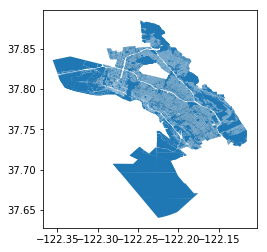

In [201]:
oakland_parcels_zone.plot()

## Vacancy

#### Vacant Use Codes
800: Vacant residential tract lot  
1000: Vacant residential land, zoned 4 units or less  
1040: Vacant residential land, R&T 402.1  
3000: Vacant commercial land (may include misc. imps)  
4000: Vacant industrial land (may include misc. imps)  
5000: Vacant rural-res homesites, may incl misc. imps  
5700: Vacant rural land, not usable even for agriculture  
5900: Vacant rural land, non-renewal Williamson Act  
6000: Vacant land necessary part of institutional prop.  
6001: Government owned property - vacant land  
7000: Vacant apartment land, capable of 5 or more units  
7040: Vacant apartment land, R&T 402.1  
7090: Vacant apartment common area or use

In [229]:
vacant_parcels_zone = oakland_parcels_zone[oakland_parcels_zone['Use Code'].isin(['800', '1000', '1040', '3000', '4000', '5000','5700', '5900', '6000', '6001', '7000', '7040', '7090'])]

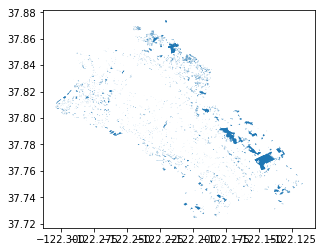

In [235]:
vacant_parcels_zone.plot()


In [227]:
#filtering oakland_parcels to use codes with "vacant" in description
vacant_parcels = oakland_parcels[oakland_parcels['Use Code'].isin(['800', '1000', '1040', '3000', '4000', '5000','5700', '5900', '6000', '6001', '7000', '7040', '7090'])]

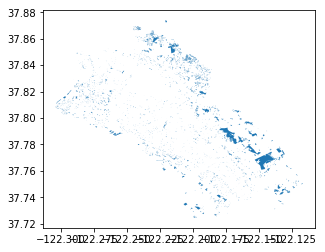

In [236]:
vacant_parcels.plot()

In [243]:
#projecting to MTC standard (Universal Transverse Mercator (UTM), Zone 10N, NAD83)
mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
vacant_parcels_proj = vacant_parcels.to_crs(mtc_crs)

In [250]:
#export to csv
vacant_parcels_proj.to_csv('data/vacant_parcels.csv')

## Tracts

In [ ]:
tracts = gpd.read_file('Alameda County US Census Tracts 2010/geo_export_90da157e-1183-4f96-ae48-e70be0e65a06.shp')

In [ ]:
tracts = tracts.drop(['funcstat10', 'geoid10', 'countyfp10', 'namelsad10', 'awater10', 'statefp10', 'intptlat10', 'intptlon10', 'aland10', 'mtfcc10', 'name10'],1)

In [ ]:
citylimits = gpd.read_file('City of Oakland City Limits/geo_export_d9d8cc59-2c85-415c-bc13-d26992faaab8.shp')

In [151]:
#get tracts for oakland
oakland_tracts = gpd.sjoin(tracts, citylimits, how="inner", op='intersects')
oakland_tracts = oakland_tracts.drop(['index_right','shape_area', 'shape_leng', 'name', 'objectid_1', 'shape_le_1', 'id','objectid'],1)

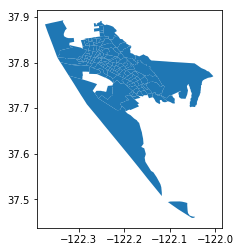

In [150]:
oakland_tracts.plot()

In [153]:
oakland_census = pd.merge(oakland_tracts, census, left_on="tractce10", right_on="tract", how="inner")

In [155]:
oakland_census.head()

,tractce10,geometry,income,households,tract
0,405800,POLYGON ((-122.2284180000002 37.79137600000006...,43278,1365,405800
1,432200,POLYGON ((-122.1612980000002 37.73726900000005...,61094,1666,432200
2,402900,POLYGON ((-122.2654490000002 37.80633800000005...,31319,851,402900
3,407300,POLYGON ((-122.2033600000002 37.76243500000005...,51042,720,407300
4,423800,POLYGON ((-122.2419250000002 37.85201700000005...,135278,1300,423800


In [ ]:
census_tracts = gpd.sjoin(oakland_census, oakland_parcels, how="inner", op='intersects')

In [ ]:
census_tracts = census_tracts.drop(['tract', 'index_right','apn', 'parcel', 'date_creat', 'Sort Parcel','Situs Street Number', 'Situs Street Name', 'Situs City', 'Situs Zip', 'Latest Document Prefix','Latest Document Series', 'Latest Document Date'],1)

In [165]:
census_tracts.head()

,tractce10,geometry,income,households,apn_sort,Land,Imps,Total Net Value,Use Code
0,405800,POLYGON ((-122.2284180000002 37.79137600000006...,43278,1365,022 035403301,66943,457110,525950,7700
0,405800,POLYGON ((-122.2284180000002 37.79137600000006...,43278,1365,022 035403400,28036,65968,94004,1100
0,405800,POLYGON ((-122.2284180000002 37.79137600000006...,43278,1365,022 035403500,37741,88064,125805,2600
0,405800,POLYGON ((-122.2284180000002 37.79137600000006...,43278,1365,022 034602100,52967,123407,169374,1100
0,405800,POLYGON ((-122.2284180000002 37.79137600000006...,43278,1365,022 035504200,115908,270453,386361,2300


In [244]:
#projecting to mtc crs
census_tracts_proj = census_tracts.to_crs(mtc_crs)

In [249]:
#export to csv
census_tracts_proj.to_csv('data/census_tracts.csv')

## Point Data

In [255]:
#getting point data for parcels
vacant_parcels_proj['Point']=vacant_parcels_proj['geometry'].centroid
vacant_parcels_point = vacant_parcels_proj.drop(['geometry'],1)
vacant_parcels_point.head()

,apn_sort,Situs Street Number,Situs Street Name,Situs City,Situs Zip,Land,Imps,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code,Point
12,048 622603302,"10,838",MONAN ST,OAKLAND,94603,14032,0,14032,"1,997","145,142",06/12/1997 12:00:00 AM,1000,POINT (576855.1953834846 4178702.69939271)
67,048 622603400,"10,830",MONAN ST,OAKLAND,94603,14032,0,14032,"1,997","145,142",06/12/1997 12:00:00 AM,1000,POINT (576858.2631909454 4178718.904293639)
102,048 622603101,NaN,MONAN ST,OAKLAND,94603,14032,0,14032,"1,997","145,142",06/12/1997 12:00:00 AM,1000,POINT (576851.9911700762 4178673.159964592)
113,048 633000704,NaN,GRASS VALLEY RD,OAKLAND,94603,81443,0,81443,"2,006","135,203",04/06/2006 12:00:00 AM,1000,POINT (577336.1958273546 4178611.179927636)
131,048 622900200,NaN,MONAN ST,OAKLAND,94603,22274,0,22274,"2,001","382,779",10/08/2001 12:00:00 AM,1000,POINT (576731.1352867181 4178858.474991242)


#### BART

In [ ]:
bart = gpd.read_file('BART_Sta_13/BART_Sta_13.shp')

#### Schools

In [ ]:
#loading schools and splitting lat and long into separate columns
schools = pd.read_csv('Map_of_Oakland_Public_Schools.csv')
schools['LATITUDE'] = schools['ADDRESS'].str.split('\n').str[2].str.split(',').str[0].str[1:].astype('float')
schools['LONGITUDE'] = schools['ADDRESS'].str.split('\n').str[2].str.split(',').str[1].str[:-1].astype('float')

In [194]:
#geocoding schools as point data
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(schools.LONGITUDE, schools.LATITUDE)]
geoschools = GeoDataFrame(schools, crs=crs, geometry=geometry)
geoschools = geoschools.drop(['PHONE','ADDRESS','LATITUDE','LONGITUDE'],1)
geoschools.head()

,TYPE,SCHOOL,geometry
0,Charter,CONSERVATORY OF INSTRUMENTAL AND VOCAL ARTS (C...,POINT (-122.1848741187958 37.79885815810979)
1,Charter,ARISE HIGH SCHOOL,POINT (-122.2249838813026 37.77616826331058)
2,Middle,ALLIANCE ACADEMY,POINT (-122.165601647708 37.74664352108863)
3,High,BUNCHE ACADEMY,POINT (-122.2868910674102 37.81300326856226)
4,Elementary,INTERNATIONAL COMM. ELEMENTARY,POINT (-122.2300110914464 37.77981951074952)


In [256]:
geoschools.to_csv('data/schools.csv')

#### Parks

In [261]:
#loading parks and splitting lat and long into separate columns
parks = pd.read_csv('Map_of_Parks_and_Recreation_Facilities.csv')
parks['Latitude'] = parks['Location 1'].str.split('\n').str[2].str.split(',').str[0].str[1:].astype('float')
parks['Longitude'] = parks['Location 1'].str.split('\n').str[2].str.split(',').str[1].str[0:-1].astype('float')
parks = parks.drop(['Phone Number','URL','Location 1'],1)
parks.head()

,Parks and Recreation Facilities,Facility Type,Latitude,Longitude
0,Lake Merritt Sail Boat House,Rental Facility,37.806761,-122.256625
1,Brookdale,Tennis Court,37.805060,-122.273020
2,Allendale Park,Park,37.789919,-122.202924
3,Park Blvd Plaza Park,Park,37.800631,-122.247661
4,Rainbow,Recreation Center,37.765493,-122.200297


In [262]:
parks.to_csv('data/parks2.csv')

In [198]:
#geocoding parks as point data
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(parks.Longitude, parks.Latitude)]
geoparks = GeoDataFrame(parks, crs=crs, geometry=geometry)
geoparks.head()

,Parks and Recreation Facilities,Facility Type,geometry
0,Lake Merritt Sail Boat House,Rental Facility,POINT (-122.2566247980454 37.80676133380701)
1,Brookdale,Tennis Court,POINT (-122.2730199996731 37.80505999961946)
2,Allendale Park,Park,POINT (-122.2029235119239 37.78991889713853)
3,Park Blvd Plaza Park,Park,POINT (-122.2476606965575 37.80063109648487)
4,Rainbow,Recreation Center,POINT (-122.2002974915983 37.76549331082276)


In [257]:
geoparks.to_csv('data/parks.csv')

## Calculations

In [81]:
#groupby use codes for summary stats
zip_values = vacant_parcels_proj['Total Net Value'].groupby(vacant_parcels_clean_proj['Situs Zip']).sum()
zip_values

Situs Zip
93602        34173
94504        62133
94546       265064
94577       781470
94601     39253121
94602      7272768
94603    117826506
94605    111440849
94606     48797229
94607    137880719
94608     65863274
94609     54033617
94610      7079570
94611    104415786
94612    198466908
94613            0
94614        37289
94618     67393909
94619     21237183
94621     70518887
94702        84104
94704      1584919
94705     16289984
Name: Total Net Value, dtype: int64

In [ ]:
#value, area by tract
#value, area by zip or tract
#value, area by use code
#value, area by zone

In [74]:
#add parcel area
vacant_parcels_clean_proj['Parcel Area'] = vacant_parcels_clean_proj.area/3.861e-7

In [79]:
#summary calculations
total_value = vacant_parcels_proj['Total Net Value'].sum()
median_value = vacant_parcels_proj['Total Net Value'].median()

total_land = vacant_parcels_proj['Land'].sum()
median_land = vacant_parcels_proj['Land'].median()

total_imps = vacant_parcels_proj['Imps'].sum()
median_imps = vacant_parcels_proj['Imps'].median()

total_area = vacant_parcels_proj['Parcel Area'].sum()
#15,613,832,452,577.998
median_area = vacant_parcels_proj['Parcel Area'].median()
#1,430,580,226.2474828

15613832452577.998

## BART

In [ ]:
bart_proj.plot()

# Ignore Below (Notes)

## Folium

## Exporting

In [ ]:
#exporting to csv
with open('data/xxxx.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["neighborhood_cleaned", "price_cleaned", "bedrooms_cleaned"])
    writer.writerows(rentals_cleaned)

## Other